In [1]:
from scipy.stats import multinomial
import numpy as np

n_samples = 1000
category1 = multinomial.rvs(n=1, p=[0.3, 0.7, 0.1], size=n_samples)
category2 = multinomial.rvs(n=1, p=[0.025, 0.025, 0.95], size=n_samples)

categories = np.concatenate([category1, category2], axis=0)
time = np.arange(2 * n_samples) / 1000


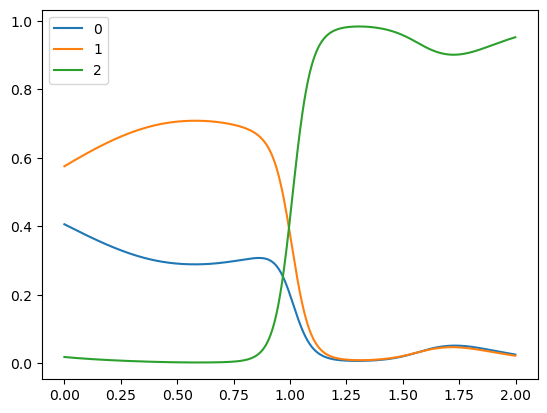

In [2]:
from sklearn.linear_model import LogisticRegression
from patsy import dmatrix
import matplotlib.pyplot as plt

design_matrix = dmatrix("1 + cr(time, df=5, constraints='center')", {"time": time})
# design_matrix = dmatrix("1 + bs(time, df=3)", {"time": time}, return_type="dataframe")

sklearn_model = LogisticRegression(fit_intercept=False, solver="newton-cg").fit(design_matrix, np.argmax(categories, axis=1))

sklearn_prob = sklearn_model.predict_proba(design_matrix)

plt.plot(time, sklearn_prob)
plt.legend(["0", "1", "2"])

Optimization terminated successfully.
         Current function value: 0.157795
         Iterations: 8
         Function evaluations: 8
         Gradient evaluations: 8
         Hessian evaluations: 8


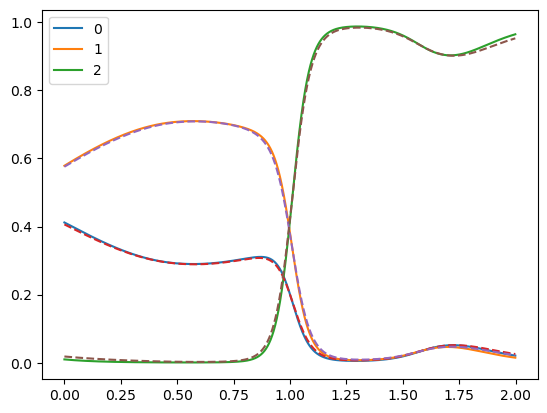

In [3]:
from src.estimate_transition import multinomial_neg_log_likelihood, multinomial_gradient, multinomial_hessian
from scipy.optimize import minimize
from src.hmm import centered_softmax_forward

n_coefficients = design_matrix.shape[1]
n_states = categories.shape[1]
start_probs = np.zeros((n_coefficients, n_states - 1))

result = minimize(
    multinomial_neg_log_likelihood,
    x0=start_probs.ravel(),
    method="Newton-CG",
    jac=multinomial_gradient,
    hess=multinomial_hessian,
    args=(
        design_matrix,
        categories.astype(float),
        1e-5
    ),
    options={"disp": True, "maxiter": 100},
)

estimated_coef = result.x.reshape((n_coefficients, n_states - 1))
prob = centered_softmax_forward(design_matrix @ estimated_coef)

plt.plot(time, prob)
plt.plot(time, sklearn_prob, linestyle="--")
plt.legend(["0", "1", "2"])

Optimization terminated successfully.
         Current function value: 0.019040
         Iterations: 11
         Function evaluations: 12
         Gradient evaluations: 12
         Hessian evaluations: 11


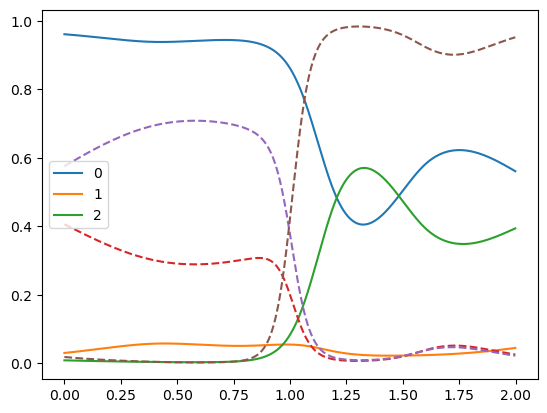

In [11]:
n_coefficients = design_matrix.shape[1]
n_states = categories.shape[1]
start_probs = np.zeros((n_coefficients, n_states - 1))

result = minimize(
    multinomial_neg_log_likelihood,
    x0=start_probs.ravel(),
    method="Newton-CG",
    jac=multinomial_gradient,
    hess=multinomial_hessian,
    args=(
        design_matrix,
        categories.astype(float) * np.array([0.95, 0.025, 0.025])[np.newaxis],
        1e-5
    ),
    options={"disp": True, "maxiter": 100},
)

estimated_coef = result.x.reshape((n_coefficients, n_states - 1))
prob = centered_softmax_forward(design_matrix @ estimated_coef)

plt.plot(time, prob)
plt.plot(time, sklearn_prob, linestyle="--")
plt.legend(["0", "1", "2"])

array([[0.5, 0. , 0. ],
       [0.5, 0. , 0. ],
       [0. , 1. , 0. ],
       ...,
       [0. , 0. , 1. ],
       [0. , 0. , 1. ],
       [0. , 0. , 1. ]])